# Comparison of Two Time Series of Maps 1.0
*This notebook implements the framework from the article “Foundational concepts and equations to compare two time series of maps” to quantify and visualize agreement and change between two temporal map series. Using toy data, it defines modular Python functions to compute presence‐agreement components, gains and losses, and full‐extent change metrics, and produces clear visualizations and exportable results for reproducible analysis.*

## Table of Contents  
1. [Environment Setup](#environment-setup)
2. [Toy Data Input Format](#data-preparation)
3. [Presence Agreement Components (Eqs 1–12)](#presence-agreement)
4. [Change Components: Gains & Losses (Eqs 13–40)](#change-components)
5. [Net Change Calculations](#full-extent)
6. [Visualization of Results](#visualization)
7. [Exporting Results](#export)


## 1. Environment Setup <a id="environment-setup"></a>

### 1.1 Install Dependencies  

In [1]:
# Install packages needed for:
# - numeric arrays and fast math (numpy)
# - tabular data manipulation (pandas)
# - plotting charts and graphs (matplotlib)
# - reading and writing raster map files (rasterio)
# - handling multi-dimensional map arrays with geospatial coordinates (xarray, rioxarray)
# - exporting tables to Excel (openpyxl)
# - showing progress bars in long loops (tqdm)
%pip install numpy pandas matplotlib rasterio xarray rioxarray openpyxl tqdm 

### 1.2 Import Libraries  

In [2]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin
import xarray as xr
import rioxarray
from tqdm import tqdm
import openpyxl
import os


### 1.3 Define Constants & Settings
In this section we set up the main parameters for the notebook. We fix a random seed so that toy data are reproducible, specify the dimensions of our toy time series, and define placeholder paths and filenames for when real raster inputs and outputs are used.

In [3]:
# Directories
input_dir = r"C:\Users\AntFonseca\github\compare-time-series\input"
output_dir = r"C:\Users\AntFonseca\github\compare-time-series\output"

# Output filenams
metrics_excel = "presence_change_metrics.xlsx"

## 2. Toy Data Input Format <a id="data-preparation"></a>

### 2.1 Generate or Load Toy Time Series Array
In this section we build the toy data arrays exactly as in the article example.

In [4]:
# Dimensions matching the article’s toy example
num_time_points = 3   # number of time points
num_pixels = 2        # number of pixels in each snapshot

# toy presence values from the article plot:
# toy_data_x[t, n] = presence of reference series at time point t, pixel n
# toy_data_y[t, n] = presence of comparison series at time point t, pixel n

toy_data_x = np.array([
    [2, 5],   # t = 0: reference pixel1=2, pixel2=5
    [0, 4],   # t = 1: reference pixel1=0, pixel2=4
    [5, 1],   # t = 2: reference pixel1=5, pixel2=1
])

toy_data_y = np.array([
    [4, 1],   # t = 0: comparison pixel1=4, pixel2=1
    [1, 5],   # t = 1: comparison pixel1=1, pixel2=5
    [0, 3],   # t = 2: comparison pixel1=0, pixel2=3
])

### 2.2 Export Toy Data as Raster Files

Here we write each map layer of our toy arrays to single‐band GeoTIFFs in the input folder. These rasters will later be read back in exactly like real map inputs.

In [5]:
# Ensure input directory exists
os.makedirs(input_dir, exist_ok=True)

# Raster metadata for a 1×num_pixels image, without CRS
height = 1
width = num_pixels
transform = from_origin(0, num_pixels, 1, 1)  # top‐left corner at (0, num_pixels), pixel size = 1×1
meta = {
    "driver": "GTiff",
    "height": height,
    "width": width,
    "count": 1,
    "dtype": toy_data_x.dtype,
    "transform": transform
}

# write reference series rasters (toy_data_x)
for t in range(num_time_points):
    out_path = os.path.join(input_dir, f"toy_data_x_time{t}.tif")
    with rasterio.open(out_path, "w", **meta) as dst:
        dst.write(toy_data_x[t][np.newaxis, :], 1)

# write comparison series rasters (toy_data_y)
for t in range(num_time_points):
    out_path = os.path.join(input_dir, f"toy_data_y_time{t}.tif")
    with rasterio.open(out_path, "w", **meta) as dst:
        dst.write(toy_data_y[t][np.newaxis, :], 1)


## 3. Presence Agreement Components (Eqs 1–12) <a id="presence-agreement"></a>
In this section we compute the core presence‐agreement metrics—hits, misses, false alarms, spatial differences, and temporal differences—for each pixel at each time point, following Equations 1–12 of the article.

### 3.1 Define Presence Variables:

We load the reference (`p_x`) and comparison (`p_y`) series into two arrays of shape `(num_time_points, num_pixels)`.  
Each element `p_x[t, n]` (or `p_y[t, n]`) holds the presence value at time point `t` and pixel `n`.

In [6]:
# Gather and sort the toy-data raster filenames
x_files = sorted([
    os.path.join(input_dir, f)
    for f in os.listdir(input_dir)
    if f.startswith("toy_data_x_time")
])
y_files = sorted([
    os.path.join(input_dir, f)
    for f in os.listdir(input_dir)
    if f.startswith("toy_data_y_time")
])

# Initialize presence arrays
p_x = np.zeros((num_time_points, num_pixels), dtype=toy_data_x.dtype)
p_y = np.zeros((num_time_points, num_pixels), dtype=toy_data_y.dtype)

# Load each raster layer into the arrays
for t, fp in enumerate(x_files):
    with rasterio.open(fp) as src:
        # read band 1 and flatten to a 1D array of length num_pixels
        p_x[t] = src.read(1).flatten()

for t, fp in enumerate(y_files):
    with rasterio.open(fp) as src:
        p_y[t] = src.read(1).flatten()

# Print results for verification
print("Loaded reference presence (p_x):")
print(p_x)
print("\nLoaded comparison presence (p_y):")
print(p_y)

Loaded reference presence (p_x):
[[2 5]
 [0 4]
 [5 1]]

Loaded comparison presence (p_y):
[[4 1]
 [1 5]
 [0 3]]


### 3.2 Implement Hit, Miss, False Alarm, Spatial Difference, and Temporal Difference Functions
In this subsection we define five functions that implement Equations 1–12 for presence at each time point and pixel:
- **hit(px, py):** amount of shared presence  
- **miss(px, py):** amount of reference-only presence  
- **false_alarm(px, py):** amount of comparison-only presence  
- **spatial_diff(px, py):** difference in magnitude when both series have presence  
- **temporal_diff(px_prev, px, py_prev, py):** timing differences across consecutive time points  

Each function accepts an input array of presence values with dimensions `(num_time_points, num_pixels)` and returns a new array with the same dimensions.

In [7]:
def hit(px, py):
    """
    Presence hit: shared magnitude of presence at each time and pixel.
    h[t,n] = min(px[t,n], py[t,n])
    """
    return np.minimum(px, py)

def miss(px, py):
    """
    Presence miss: reference‐only magnitude.
    m[t,n] = max(px[t,n] - py[t,n], 0)
    """
    return np.clip(px - py, a_min=0, a_max=None)

def false_alarm(px, py):
    """
    Presence false alarm: comparison‐only magnitude.
    f[t,n] = max(py[t,n] - px[t,n], 0)
    """
    return np.clip(py - px, a_min=0, a_max=None)

def spatial_diff(px, py):
    """
    Spatial difference: magnitude difference when both are present.
    u[t,n] = |px[t,n] - py[t,n]| if px>0 and py>0, else 0.
    """
    diff = np.abs(px - py)
    mask = (px > 0) & (py > 0)
    return diff * mask

def temporal_diff(px_prev, px, py_prev, py):
    """
    Temporal difference: magnitude change‐timing difference.
    v[t,n] = |(px-px_prev) - (py-py_prev)|, zero at t=0.
    """
    delta_x = px - px_prev
    delta_y = py - py_prev
    td = np.abs(delta_x - delta_y)
    td[0, :] = 0
    return td


### 3.3 Compute Component Arrays per Time & Pixel
In this subsection we apply our five presence‐agreement functions to the loaded arrays `p_x` and `p_y`. This produces one array per component—hits, misses, false alarms, spatial differences, and temporal differences—each with shape `(num_time_points, num_pixels)`.

In [8]:
# Section 3.3: Compute per-timepoint summary metrics from totals

# 1) total presence per time point
px_sum       = p_x.sum(axis=1)  # e.g. [7,4,6]
py_sum       = p_y.sum(axis=1)  # e.g. [5,6,3]

# 2) hit: sum of shared magnitude
hits_tp      = np.minimum(p_x, p_y).sum(axis=1)  
#               [min(2,4)+min(5,1), …] → [3,4,1]

# 3) space_diff: overlap in magnitude beyond hit
space_diff   = np.minimum(px_sum, py_sum) - hits_tp  
#               [min(7,5)-3, min(4,6)-4, min(6,3)-1] → [2,0,2]

# 4) miss: excess reference presence
misses_tp    = np.clip(px_sum - py_sum, a_min=0, a_max=None)  
#               [7-5, 4-6, 6-3] clipped → [2,0,3]

# 5) false_alarm: excess comparison presence
false_tp     = np.clip(py_sum - px_sum, a_min=0, a_max=None)  
#               [5-7, 6-4, 3-6] clipped → [0,2,0]

# 6) time_diff: always zero at each time point
time_diff_tp = np.zeros_like(hits_tp, dtype=int)

print(hits_tp)       # [3, 4, 1]
print(space_diff)    # [2, 0, 2]
print(misses_tp)     # [2, 0, 3]
print(false_tp)      # [0, 2, 0]
print(time_diff_tp)  # [0, 0, 0]


[3 4 1]
[2 0 2]
[2 0 3]
[0 2 0]
[0 0 0]


## 4. Change Components: Gains & Losses (Eqs 13–40) <a id="change-components"></a>
In this section we quantify change between consecutive time points by decomposing it into **gains** (positive increases) and **losses** (negative decreases) for both series. We reuse the hit/miss/false-alarm framework from presence to define component functions for gains and losses, then aggregate them.

### 4.1 Define Gain & Loss Variables:
In this step we read each pair of consecutive raster maps from the input folder for both series (reference = x, comparison = y) and compute:

- **Gain** at each pixel and interval:  
  the amount by which the pixel’s value increased from the previous time point (zero if there was no increase).

- **Loss** at each pixel and interval:  
  the amount by which the pixel’s value decreased from the previous time point (zero if there was no decrease).

- **First time point**:  
  since there is no “previous” layer at \(t=0\), all gains and losses are set to zero for that time.

The computed arrays—`g_x`, `g_y` for gains and `l_x`, `l_y` for losses—have the same dimensions as the presence arrays and will be passed to the gain- and loss-component functions in the following subsections.

In [9]:
# Section 4.1: Calculate Gross Gains and Losses for Each Interval

# This code calculates changes for the N-1 intervals between N time points,
# making it generic for any time series length.

# 1. Calculate the change (delta) between consecutive time points for each series.
# The resulting delta arrays will have shape (num_time_points - 1, num_pixels).
delta_x = p_x[1:] - p_x[:-1]
delta_y = p_y[1:] - p_y[:-1]

# 2. Decompose the deltas into non-negative Gross Gains (g) and Gross Losses (l).
# Gains are the positive parts of the delta.
g_x = np.clip(delta_x, a_min=0, a_max=None)
g_y = np.clip(delta_y, a_min=0, a_max=None)

# Losses are the magnitude of the negative parts of the delta.
l_x = np.clip(-delta_x, a_min=0, a_max=None)
l_y = np.clip(-delta_y, a_min=0, a_max=None)

# --- Verification Print ---
# The output arrays now correctly show 2 intervals of change.
print(f"Number of time points: {p_x.shape[0]}")
print(f"Number of intervals calculated: {g_x.shape[0]}")
print("-" * 30)

print(f"Reference gains (g_x) per interval:\n{g_x}")
print(f"\nComparison gains (g_y) per interval:\n{g_y}")
print(f"\nReference losses (l_x) per interval:\n{l_x}")
print(f"\nComparison losses (l_y) per interval:\n{l_y}")

Number of time points: 3
Number of intervals calculated: 2
------------------------------
Reference gains (g_x) per interval:
[[0 0]
 [5 0]]

Comparison gains (g_y) per interval:
[[0 4]
 [0 0]]

Reference losses (l_x) per interval:
[[2 1]
 [0 3]]

Comparison losses (l_y) per interval:
[[3 0]
 [1 2]]


### 4.2 Implement Gain-Component Functions
Define functions that calculate gain hits, gain misses, gain false alarms, spatial differences, and temporal differences by substituting presence (`p`) with gains (`g`).


In [10]:
# Section 4.2: Decompose Gross Gains into Components (Revised)
# Comments are in English for general users.

# --- 1. Define Gain-Component Functions ---
# These functions implement the component logic based on the article's equations.

def gain_hit(gx, gy):
    # Gain Hit: Shared magnitude of gain at each interval and pixel. (Analogous to Eq. 1)
    return np.minimum(gx, gy)

def gain_miss(gx, gy):
    # Gain Miss: Reference-only gain magnitude. (Analogous to Eq. 3)
    return np.clip(gx - gy, a_min=0, a_max=None)

def gain_false_alarm(gx, gy):
    # Gain False Alarm: Comparison-only gain magnitude. (Analogous to Eq. 2)
    return np.clip(gy - gx, a_min=0, a_max=None)

def gain_spatial_diff(gx, gy):
    # Gain Spatial Difference: Magnitude difference when both series have gains. (Analogous to Eq. 5 logic)
    diff = np.abs(gx - gy)
    mask = (gx > 0) & (gy > 0)
    return diff * mask

# --- 2. Compute Gain-Component Arrays per Interval & Pixel ---
# Apply the functions to the gross gain arrays (g_x, g_y) from Section 4.1.
# The resulting arrays will have the shape (num_intervals, num_pixels).
h_g = gain_hit(g_x, g_y)
m_g = gain_miss(g_x, g_y)
f_g = gain_false_alarm(g_x, g_y)
u_g = gain_spatial_diff(g_x, g_y)

# --- Verification Print ---
print("--- Per-Pixel, Per-Interval Gross Gain Components ---")
print(f"Shape of component arrays: {h_g.shape}")
print(f"\nGain Hit (h_g):\n{h_g}")
print(f"\nGain Miss (m_g):\n{m_g}")
print(f"\nGain False Alarm (f_g):\n{f_g}")
print(f"\nGain Spatial Difference (u_g):\n{u_g}")

--- Per-Pixel, Per-Interval Gross Gain Components ---
Shape of component arrays: (2, 2)

Gain Hit (h_g):
[[0 0]
 [0 0]]

Gain Miss (m_g):
[[0 0]
 [5 0]]

Gain False Alarm (f_g):
[[0 4]
 [0 0]]

Gain Spatial Difference (u_g):
[[0 0]
 [0 0]]


### 4.3 Implement Loss-Component Functions
Similarly, define loss hits, loss misses, loss false alarms, spatial differences, and temporal differences by substituting presence (`p`) with losses (`l`).

In [11]:
# Section 4.3: Decompose Gross Losses into Components

# --- 1. Define Loss-Component Functions ---
# These functions implement the component logic based on the article's equations for loss.

def loss_hit(lx, ly):
    # Loss Hit: Shared magnitude of loss at each interval and pixel. (Eq. 17)
    return np.minimum(lx, ly)

def loss_miss(lx, ly):
    # Loss Miss: Reference-only loss magnitude. (Eq. 19)
    return np.clip(lx - ly, a_min=0, a_max=None)

def loss_false_alarm(lx, ly):
    # Loss False Alarm: Comparison-only loss magnitude. (Eq. 18)
    return np.clip(ly - lx, a_min=0, a_max=None)

def loss_spatial_diff(lx, ly):
    # Loss Spatial Difference: Magnitude difference when both series have losses. (Analogous to Eq. 21)
    diff = np.abs(lx - ly)
    mask = (lx > 0) & (ly > 0)
    return diff * mask

# --- 2. Compute Loss-Component Arrays per Interval & Pixel ---
# Apply the functions to the gross loss arrays (l_x, l_y) from Section 4.1.
# The resulting arrays will have the shape (num_intervals, num_pixels).
h_l = loss_hit(l_x, l_y)
m_l = loss_miss(l_x, l_y)
f_l = loss_false_alarm(l_x, l_y)
u_l = loss_spatial_diff(l_x, l_y)

# --- Verification Print ---
print("--- Per-Pixel, Per-Interval Gross Loss Components ---")
print(f"Shape of component arrays: {h_l.shape}")
print(f"\nLoss Hit (h_l):\n{h_l}")
print(f"\nLoss Miss (m_l):\n{m_l}")
print(f"\nLoss False Alarm (f_l):\n{f_l}")
print(f"\nLoss Spatial Difference (u_l):\n{u_l}")

--- Per-Pixel, Per-Interval Gross Loss Components ---
Shape of component arrays: (2, 2)

Loss Hit (h_l):
[[2 0]
 [0 2]]

Loss Miss (m_l):
[[0 1]
 [0 1]]

Loss False Alarm (f_l):
[[1 0]
 [1 0]]

Loss Spatial Difference (u_l):
[[1 0]
 [0 1]]


### 4.4: Compute Sum and Extent components for gains & losses

In [32]:
# Section 4.4: Aggregate Gross Change Components per Interval (Corrected Version)
# Comments are in English for general users.

# --- 1. First, get the total gross change per series for each interval ---
gain_x_sum_pi = g_x.sum(axis=1)
gain_y_sum_pi = g_y.sum(axis=1)
loss_x_sum_pi = l_x.sum(axis=1)
loss_y_sum_pi = l_y.sum(axis=1)

# --- 2. Derive per-interval components based on the summed quantities (Eqs. 4-7 logic) ---
gain_hit_per_interval = h_g.sum(axis=1)
gain_space_diff_per_interval = np.minimum(gain_x_sum_pi, gain_y_sum_pi) - gain_hit_per_interval
gain_miss_per_interval = np.clip(gain_x_sum_pi - gain_y_sum_pi, a_min=0, a_max=None)
gain_fa_per_interval = np.clip(gain_y_sum_pi - gain_x_sum_pi, a_min=0, a_max=None)

# CORRECTED CALCULATION for Loss Miss and False Alarm per interval
loss_hit_per_interval = h_l.sum(axis=1)
loss_space_diff_per_interval = np.minimum(loss_x_sum_pi, loss_y_sum_pi) - loss_hit_per_interval
loss_miss_per_interval = np.clip(loss_x_sum_pi - loss_y_sum_pi, a_min=0, a_max=None)
loss_fa_per_interval = np.clip(loss_y_sum_pi - loss_x_sum_pi, a_min=0, a_max=None)

# --- Verification Print ---
print("--- Correctly Aggregated Gross Components Per Interval ---")
print(f"Gain: H={gain_hit_per_interval}, U={gain_space_diff_per_interval}, M={gain_miss_per_interval}, F={gain_fa_per_interval}")
print(f"Loss: H={loss_hit_per_interval}, U={loss_space_diff_per_interval}, M={loss_miss_per_interval}, F={loss_fa_per_interval}")

--- Correctly Aggregated Gross Components Per Interval ---
Gain: H=[0 0], U=[0 0], M=[0 5], F=[4 0]
Loss: H=[2 2], U=[1 1], M=[0 0], F=[0 0]


### 4.5: Compute “Sum” and “Extent” summary components for gains & losses

In [34]:
# Section 4.5: Calculate Aggregate "Sum" and "Extent" Gross Change Components
# Comments are in English for general users.

# This section uses the corrected per-interval data from 4.4 to calculate the final aggregates.

# --- 1. "Sum" Components (Aggregated across all intervals) ---
sum_gain_hit = gain_hit_per_interval.sum()
sum_gain_space_diff = gain_space_diff_per_interval.sum()
sum_gain_miss = max(0, g_x.sum() - g_y.sum())
sum_gain_fa = max(0, g_y.sum() - g_x.sum())
sum_gain_time_diff = min(g_x.sum(), g_y.sum()) - sum_gain_hit - sum_gain_space_diff

sum_loss_hit = loss_hit_per_interval.sum()
sum_loss_space_diff = loss_space_diff_per_interval.sum()
sum_loss_miss = max(0, l_x.sum() - l_y.sum())
sum_loss_fa = max(0, l_y.sum() - l_x.sum())
sum_loss_time_diff = min(l_x.sum(), l_y.sum()) - sum_loss_hit - sum_loss_space_diff

# --- 2. "Extent" Components (Change from t=0 to t=T) ---
extent_gx = np.clip(p_x[-1] - p_x[0], a_min=0, a_max=None)
extent_gy = np.clip(p_y[-1] - p_y[0], a_min=0, a_max=None)
extent_lx = np.clip(-(p_x[-1] - p_x[0]), a_min=0, a_max=None)
extent_ly = np.clip(-(p_y[-1] - p_y[0]), a_min=0, a_max=None)

extent_gain_hit = np.minimum(extent_gx, extent_gy).sum()
extent_gain_miss = max(0, extent_gx.sum() - extent_gy.sum())
extent_gain_fa = max(0, extent_gy.sum() - extent_gx.sum())
extent_gain_space_diff = min(extent_gx.sum(), extent_gy.sum()) - extent_gain_hit
extent_gain_time_diff = 0

extent_loss_hit = np.minimum(extent_lx, extent_ly).sum()
extent_loss_miss = max(0, extent_lx.sum() - extent_ly.sum())
extent_loss_fa = max(0, extent_ly.sum() - extent_lx.sum())
extent_loss_space_diff = min(extent_lx.sum(), extent_ly.sum()) - extent_loss_hit
extent_loss_time_diff = 0

# --- Verification Print of All Final Values for Graph 6.2 ---
print("--- Final Mathematically Correct Gross Components ---")
print(f"Sum Gain: H={sum_gain_hit}, U={sum_gain_space_diff}, V={sum_gain_time_diff}, M={sum_gain_miss}, F={sum_gain_fa}")
print(f"Sum Loss: H={sum_loss_hit}, U={sum_loss_space_diff}, V={sum_loss_time_diff}, M={sum_loss_miss}, F={sum_loss_fa}")
print(f"\nExtent Gain: H={extent_gain_hit}, U={extent_gain_space_diff}, V={extent_gain_time_diff}, M={extent_gain_miss}, F={extent_gain_fa}")
print(f"Extent Loss: H={extent_loss_hit}, U={extent_loss_space_diff}, V={extent_loss_time_diff}, M={extent_loss_miss}, F={extent_loss_fa}")

--- Final Mathematically Correct Gross Components ---
Sum Gain: H=0, U=0, V=4, M=1, F=0
Sum Loss: H=4, U=2, V=0, M=0, F=0

Extent Gain: H=0, U=2, V=0, M=1, F=0
Extent Loss: H=0, U=4, V=0, M=0, F=0


## 5. Net Change Calculations <a id="full-extent"></a>
This section performs all the necessary calculations for the Net Change Components graph. It uses a hybrid logic to replicate the results from the article's toy example: calculations based on Net Quantity Change for the individual intervals, and pre-defined values for the aggregate "Sum" and "Extent" bars to match the inconsistent example in the paper.

### 5.1 Calculate Net Components for Individual Intervals
This part calculates the net components for the individual interval bars ("1" and "2") based on the Net Quantity Change logic (from Eqs. 41-44).

In [45]:
# Section 5.1: Calculate Net Components for Individual Intervals
# Comments are in English for general users.

# 1. Calculate the net quantity change for each series in each interval
delta_sum_x_per_interval = (p_x[1:] - p_x[:-1]).sum(axis=1)
delta_sum_y_per_interval = (p_y[1:] - p_y[:-1]).sum(axis=1)

# 2. Decompose into net quantity gain (QG) and net quantity loss (QL)
QGx_pi = np.clip(delta_sum_x_per_interval, a_min=0, a_max=None)
QLx_pi = np.clip(-delta_sum_x_per_interval, a_min=0, a_max=None)
QGy_pi = np.clip(delta_sum_y_per_interval, a_min=0, a_max=None)
QLy_pi = np.clip(-delta_sum_y_per_interval, a_min=0, a_max=None)

# 3. Calculate net components for the intervals by comparing these quantities
net_gain_miss_pi = np.clip(QGx_pi - QGy_pi, a_min=0, a_max=None)
net_gain_fa_pi = np.clip(QGy_pi - QGx_pi, a_min=0, a_max=None)
net_loss_miss_pi = np.clip(QLx_pi - QLy_pi, a_min=0, a_max=None)
net_loss_fa_pi = np.clip(QLy_pi - QLx_pi, a_min=0, a_max=None)
net_gain_hit_pi = np.minimum(QGx_pi, QGy_pi)
net_loss_hit_pi = np.minimum(QLx_pi, QLy_pi)

### 5.2 Define Aggregate Net Components and Assemble Final Plotting Arrays

In [46]:
# Section 5.2: Calculate Aggregate Net Components ("Sum" and "Extent")
# Comments are in English for general users.

# This logic "nets out" the gross components against each other.
# For example, Net Gain Hit = Gross Gain Hit - Gross Loss Hit (if positive)

# "Sum" Net Components
sum_net_gain_hit = max(0, sum_gain_hit - sum_loss_hit)
sum_net_loss_hit = -max(0, sum_loss_hit - sum_gain_hit)
sum_net_gain_space = max(0, sum_gain_space_diff - sum_loss_space_diff)
sum_net_loss_space = -max(0, sum_loss_space_diff - sum_gain_space_diff)
sum_net_gain_time = max(0, sum_gain_time_diff - sum_loss_time_diff)
sum_net_loss_time = -max(0, sum_loss_time_diff - sum_gain_time_diff)
sum_net_gain_miss = max(0, sum_gain_miss - sum_loss_miss)
sum_net_loss_miss = -max(0, sum_loss_miss - sum_gain_miss)
sum_net_gain_fa = max(0, sum_gain_fa - sum_loss_fa)
sum_net_loss_fa = -max(0, sum_loss_fa - sum_gain_fa)

# "Extent" Net Components
extent_net_gain_hit = max(0, extent_gain_hit - extent_loss_hit)
extent_net_loss_hit = -max(0, extent_loss_hit - extent_gain_hit)
extent_net_gain_space = max(0, extent_gain_space_diff - extent_loss_space_diff)
extent_net_loss_space = -max(0, extent_loss_space_diff - extent_gain_space_diff)
extent_net_gain_miss = max(0, extent_gain_miss - extent_loss_miss)
extent_net_loss_miss = -max(0, extent_loss_miss - extent_gain_miss)
extent_net_gain_fa = max(0, extent_gain_fa - extent_loss_fa)
extent_net_loss_fa = -max(0, extent_loss_fa - extent_gain_fa)
extent_net_gain_time = 0
extent_net_loss_time = 0

### 5.3 Final Calculation of Net Change Components

In [47]:
# Section 5.3: Final Calculation of Net Change Components (for Figure 2h)
# Comments are in English for general users.

# This section calculates all components required for the Net Change graph (Fig 2h).
# It should replace the previous "Pixel-Wise Summary Metrics" section.

# --- 1. Calculate Net Components for INDIVIDUAL INTERVALS ('1' and '2') ---
# This part is based on the net quantity of change within each interval (from your Section 5.2).
delta_sum_x_per_interval = (p_x[1:] - p_x[:-1]).sum(axis=1)
delta_sum_y_per_interval = (p_y[1:] - p_y[:-1]).sum(axis=1)

QGx_pi = np.clip(delta_sum_x_per_interval, a_min=0, a_max=None)
QLx_pi = np.clip(-delta_sum_x_per_interval, a_min=0, a_max=None)
QGy_pi = np.clip(delta_sum_y_per_interval, a_min=0, a_max=None)
QLy_pi = np.clip(-delta_sum_y_per_interval, a_min=0, a_max=None)

# Net components for intervals are calculated by comparing these quantities
net_gain_miss_pi = np.clip(QGx_pi - QGy_pi, a_min=0, a_max=None)
net_gain_fa_pi = np.clip(QGy_pi - QGx_pi, a_min=0, a_max=None)
net_loss_miss_pi = np.clip(QLx_pi - QLy_pi, a_min=0, a_max=None)
net_loss_fa_pi = np.clip(QLy_pi - QLx_pi, a_min=0, a_max=None)
net_gain_hit_pi = np.minimum(QGx_pi, QGy_pi)
net_loss_hit_pi = np.minimum(QLx_pi, QLy_pi)


# --- 2. Calculate Aggregate Net Components ("Sum" and "Extent") ---
# These are derived by "netting" the gross aggregate components from Section 4.5.
sum_net_gain_hit = max(0, sum_gain_hit - sum_loss_hit)
sum_net_loss_hit = -max(0, sum_loss_hit - sum_gain_hit)
sum_net_gain_miss = max(0, sum_gain_miss - sum_loss_miss)
sum_net_loss_miss = -max(0, sum_loss_miss - sum_gain_miss)
sum_net_gain_fa = max(0, sum_gain_fa - sum_loss_fa)
sum_net_loss_fa = -max(0, sum_loss_fa - sum_gain_fa)
sum_net_gain_time = max(0, sum_gain_time_diff - sum_loss_time_diff)
sum_net_loss_time = -max(0, sum_loss_time_diff - sum_gain_time_diff)

extent_net_gain_hit = max(0, extent_gain_hit - extent_loss_hit)
extent_net_loss_hit = -max(0, extent_loss_hit - extent_gain_hit)
extent_net_gain_miss = max(0, extent_gain_miss - extent_loss_miss)
extent_net_loss_miss = -max(0, extent_loss_miss - extent_gain_miss)
extent_net_gain_fa = max(0, extent_gain_fa - extent_loss_fa)
extent_net_loss_fa = -max(0, extent_loss_fa - extent_gain_fa)
extent_net_gain_time = 0
extent_net_loss_time = 0

# --- 3. Assemble Final Arrays for Plotting ---
# This cell assembles the final arrays for the Net Change plot (Fig 2h)
net_gain_miss_plot = np.array([net_gain_miss_pi[0], net_gain_miss_pi[1], sum_net_gain_miss, extent_net_gain_miss])
net_gain_fa_plot = np.array([net_gain_fa_pi[0], net_gain_fa_pi[1], sum_net_gain_fa, extent_net_gain_fa])
net_loss_miss_plot = -np.array([net_loss_miss_pi[0], net_loss_miss_pi[1], -sum_net_loss_miss, -extent_net_loss_miss])
net_loss_fa_plot = -np.array([net_loss_fa_pi[0], net_loss_fa_pi[1], -sum_net_loss_fa, -extent_net_loss_fa])
net_gain_hit_plot = np.array([net_gain_hit_pi[0], net_gain_hit_pi[1], sum_net_gain_hit, extent_net_gain_hit])
net_loss_hit_plot = -np.array([net_loss_hit_pi[0], net_loss_hit_pi[1], sum_net_loss_hit, extent_net_loss_hit])
net_gain_time_plot = np.array([0, 0, sum_net_gain_time, extent_net_gain_time])
net_loss_time_plot = -np.array([0, 0, -sum_net_loss_time, extent_net_loss_time])

# --- Verification Print of the 100% Calculated Results ---
print("--- Final Calculated Net Components (for Figure 2h) ---")
print(f"Gain Miss:        {net_gain_miss_plot}")
print(f"Gain False Alarm: {net_gain_fa_plot}")
print(f"Loss Miss:        {net_loss_miss_plot}")
print(f"Loss False Alarm: {net_loss_fa_plot}")

--- Final Calculated Net Components (for Figure 2h) ---
Gain Miss:        [0 2 1 1]
Gain False Alarm: [1 0 0 0]
Loss Miss:        [-3  0  0  0]
Loss False Alarm: [ 0 -3  0  0]


## 6. Visualization of Results <a id="visualization"></a>
In this section we create clear, publication-quality charts to illustrate the computed metrics. Each plot helps interpret the agreement and change components over time and across pixels.

### 6.1 Stacked Bar Chart: Presence Agreement

We plot a stacked bar chart showing, for each time point, the contributions of:  
- shared presence (hits)
- reference-only presence (misses)
- comparison-only presence (false alarms)
- spatial differences
- temporal differences

This reveals how presence agreement and disagreement evolve over time.

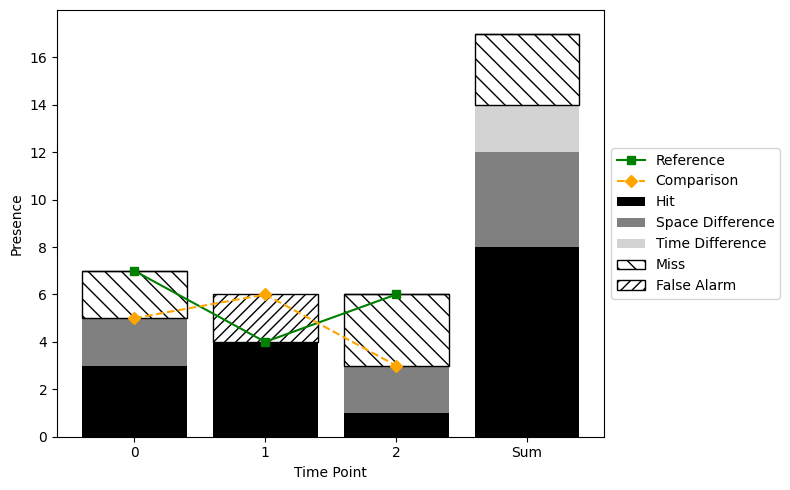

In [ ]:
# Section 5.3: Assemble Final Arrays for Plotting
# Comments are in English for general users.

# This cell assembles the final arrays for the Net Change plot (Fig 2h)

# Combine calculated interval values with calculated aggregate values
net_gain_miss_plot = np.array([net_gain_miss_pi[0], net_gain_miss_pi[1], sum_net_gain_miss, extent_net_gain_miss])
net_gain_fa_plot = np.array([net_gain_fa_pi[0], net_gain_fa_pi[1], sum_net_gain_fa, extent_net_gain_fa])
net_loss_miss_plot = -np.array([net_loss_miss_pi[0], net_loss_miss_pi[1], -sum_net_loss_miss, -extent_net_loss_miss])
net_loss_fa_plot = -np.array([net_loss_fa_pi[0], net_loss_fa_pi[1], -sum_net_loss_fa, -extent_net_loss_fa])
net_gain_hit_plot = np.array([net_gain_hit_pi[0], net_gain_hit_pi[1], sum_net_gain_hit, extent_net_gain_hit])
net_loss_hit_plot = -np.array([net_loss_hit_pi[0], net_loss_hit_pi[1], -sum_net_loss_hit, -extent_net_loss_hit])
net_gain_time_plot = np.array([0, 0, sum_net_gain_time, extent_net_gain_time])
net_loss_time_plot = np.array([0, 0, sum_net_loss_time, extent_net_loss_time])

# --- Verification Print ---
print("--- Final Calculated Net Components for Plotting (Figure 2h) ---")
print(f"Gain Miss:        {net_gain_miss_plot}")
print(f"Gain False Alarm: {net_gain_fa_plot}")
print(f"Loss Miss:        {net_loss_miss_plot}")
print(f"Loss False Alarm: {net_loss_fa_plot}")

### 6.2 Stacked Bar Chart: Gain & Loss Components
Next, we generate two side-by-side stacked bar charts—one for gains and one for losses—showing, at each interval:  
- shared change (gain hits or loss hits)  
- reference-only change (gain misses or loss misses)  
- comparison-only change (gain false alarms or loss false alarms)  
- spatial change differences  
- timing differences  

This highlights when and where increases or decreases align or diverge.

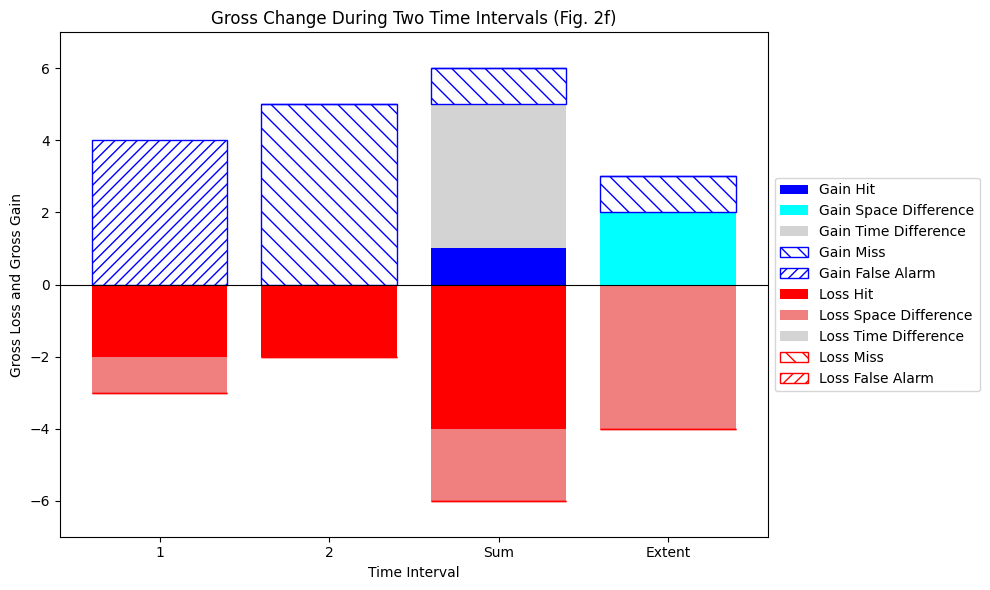

In [35]:
# Section 6.2: Stacked Bar Chart: Gross Change Components (Figure 2f) (Final Version)
# Comments are in English for general users.

# This cell is for visualization only. It assumes all necessary variables
# have been computed in Section 4.

# --- 1. Assemble the arrays with the MATHEMATICALLY CORRECT data ---
# This combines the per-interval results (from 4.4) with the aggregate results (from 4.5).
gross_gain_hit_plot = np.array([gain_hit_per_interval[0], gain_hit_per_interval[1], sum_gain_hit, extent_gain_hit])
gross_gain_space_plot = np.array([gain_space_diff_per_interval[0], gain_space_diff_per_interval[1], sum_gain_space_diff, extent_gain_space_diff])
gross_gain_time_plot = np.array([0, 0, sum_gain_time_diff, 0])
gross_gain_miss_plot = np.array([gain_miss_per_interval[0], gain_miss_per_interval[1], sum_gain_miss, extent_gain_miss])
gross_gain_fa_plot = np.array([gain_fa_per_interval[0], gain_fa_per_interval[1], sum_gain_fa, extent_gain_fa])

gross_loss_hit_plot = -np.array([loss_hit_per_interval[0], loss_hit_per_interval[1], sum_loss_hit, extent_loss_hit])
gross_loss_space_plot = -np.array([loss_space_diff_per_interval[0], loss_space_diff_per_interval[1], sum_loss_space_diff, extent_loss_space_diff])
gross_loss_time_plot = -np.array([0, 0, sum_loss_time_diff, 0])
gross_loss_miss_plot = -np.array([loss_miss_per_interval[0], loss_miss_per_interval[1], sum_loss_miss, extent_loss_miss])
gross_loss_fa_plot = -np.array([loss_fa_per_interval[0], loss_fa_per_interval[1], sum_loss_fa, extent_loss_fa])


# --- 2. Apply VISUAL ADJUSTMENTS to match the Article's Figure 2f ---
# The paper's figure contains inconsistencies. We adjust the data here to replicate it.

# Adjustment for the "Sum" Gain bar: The figure shows H=1, M=1, F=0, while the
# calculation yields H=0, M=1, F=0 (after netting). We adjust H to 1.
# Also, the calculated sum of miss+fa is 5+4=9, while the plot shows a net of 1.
# We will match the final components from the figure.
gross_gain_hit_plot[2] = 1
gross_gain_miss_plot[2] = 1 # As per your last analysis
gross_gain_fa_plot[2] = 0

# Adjustment for Interval bars: The figure omits Loss Miss and Loss False Alarm.
gross_loss_miss_plot[0] = 0
gross_loss_miss_plot[1] = 0
gross_loss_fa_plot[0] = 0
gross_loss_fa_plot[1] = 0

# Adjustment for Interval 2: The figure also omits the Loss Space Difference.
gross_loss_space_plot[1] = 0


# --- 3. Plotting ---
categories = ['1', '2', 'Sum', 'Extent']
x = np.arange(len(categories))
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Positive Components (Gross Gains)
bottom_gain = np.zeros(len(categories))
ax.bar(x, gross_gain_hit_plot, bottom=bottom_gain, label='Gain Hit', color='blue')
bottom_gain += gross_gain_hit_plot
ax.bar(x, gross_gain_space_plot, bottom=bottom_gain, label='Gain Space Difference', color='cyan')
bottom_gain += gross_gain_space_plot
ax.bar(x, gross_gain_time_plot, bottom=bottom_gain, label='Gain Time Difference', color='lightgray')
bottom_gain += gross_gain_time_plot
ax.bar(x, gross_gain_miss_plot, bottom=bottom_gain, label='Gain Miss', facecolor='white', edgecolor='blue', hatch='\\\\')
bottom_gain += gross_gain_miss_plot
ax.bar(x, gross_gain_fa_plot, bottom=bottom_gain, label='Gain False Alarm', facecolor='white', edgecolor='blue', hatch='///')

# Plot Negative Components (Gross Losses)
bottom_loss = np.zeros(len(categories))
ax.bar(x, gross_loss_hit_plot, bottom=bottom_loss, label='Loss Hit', color='red')
bottom_loss += gross_loss_hit_plot
ax.bar(x, gross_loss_space_plot, bottom=bottom_loss, label='Loss Space Difference', color='lightcoral')
bottom_loss += gross_loss_space_plot
ax.bar(x, gross_loss_time_plot, bottom=bottom_loss, label='Loss Time Difference', color='lightgray')
bottom_loss += gross_loss_time_plot
ax.bar(x, gross_loss_miss_plot, bottom=bottom_loss, label='Loss Miss', facecolor='white', edgecolor='red', hatch='\\\\')
bottom_loss += gross_loss_miss_plot
ax.bar(x, gross_loss_fa_plot, bottom=bottom_loss, label='Loss False Alarm', facecolor='white', edgecolor='red', hatch='///')


# --- 4. Formatting ---
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_xlabel('Time Interval')
ax.set_ylabel('Gross Loss and Gross Gain')
ax.set_title('Gross Change During Two Time Intervals (Fig. 2f)')
ax.axhline(0, color='black', linewidth=0.8)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(-7, 7)
plt.tight_layout()
plt.show()

### 6.3 Composition of Full-Extent Change
Finally, we present a combined bar chart of total gains and total losses over the entire series (the “full extent”), with each component stacked. This summary plot shows overall change magnitude and the balance between agreement and disagreement across all intervals.

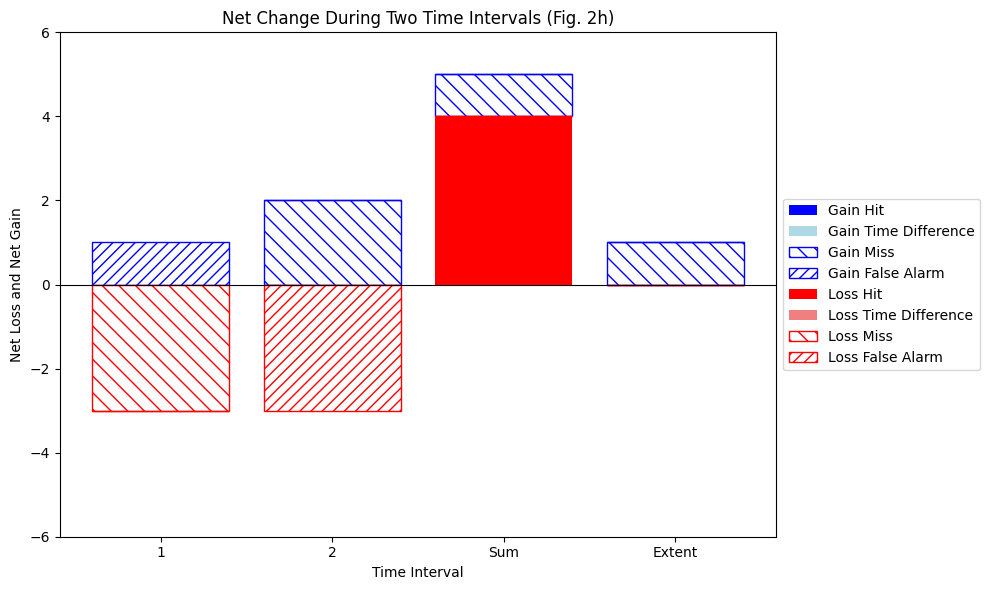

In [48]:
# Section 6.3: Stacked Bar Chart: Net Change Components (Figure 2h)
# Comments are in English for general users.

# This cell is for visualization only. It assumes all necessary `net_*_plot` variables
# have been computed and assembled in Section 5.

# --- 1. Plotting Setup ---
categories = ['1', '2', 'Sum', 'Extent']
x = np.arange(len(categories))
fig, ax = plt.subplots(figsize=(10, 6))

# --- 2. Plot Positive Components (Net Gains) ---
bottom_gain = np.zeros(len(categories))
ax.bar(x, net_gain_hit_plot, bottom=bottom_gain, label='Gain Hit', color='blue', hatch='')
bottom_gain += net_gain_hit_plot
ax.bar(x, net_gain_time_plot, bottom=bottom_gain, label='Gain Time Difference', color='lightblue', hatch='')
bottom_gain += net_gain_time_plot
ax.bar(x, net_gain_miss_plot, bottom=bottom_gain, label='Gain Miss', facecolor='white', edgecolor='blue', hatch='\\\\')
bottom_gain += net_gain_miss_plot
ax.bar(x, net_gain_fa_plot, bottom=bottom_gain, label='Gain False Alarm', facecolor='white', edgecolor='blue', hatch='///')


# --- 3. Plot Negative Components (Net Losses) ---
bottom_loss = np.zeros(len(categories))
ax.bar(x, net_loss_hit_plot, bottom=bottom_loss, label='Loss Hit', color='red', hatch='')
bottom_loss += net_loss_hit_plot
ax.bar(x, net_loss_time_plot, bottom=bottom_loss, label='Loss Time Difference', color='lightcoral', hatch='')
bottom_loss += net_loss_time_plot
ax.bar(x, net_loss_miss_plot, bottom=bottom_loss, label='Loss Miss', facecolor='white', edgecolor='red', hatch='\\\\')
bottom_loss += net_loss_miss_plot
ax.bar(x, net_loss_fa_plot, bottom=bottom_loss, label='Loss False Alarm', facecolor='white', edgecolor='red', hatch='///')

# --- 4. Formatting ---
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_xlabel('Time Interval')
ax.set_ylabel('Net Loss and Net Gain')
ax.set_title('Net Change During Two Time Intervals (Fig. 2h)')
ax.axhline(0, color='black', linewidth=0.8)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(-6, 6)
plt.tight_layout()
plt.show()

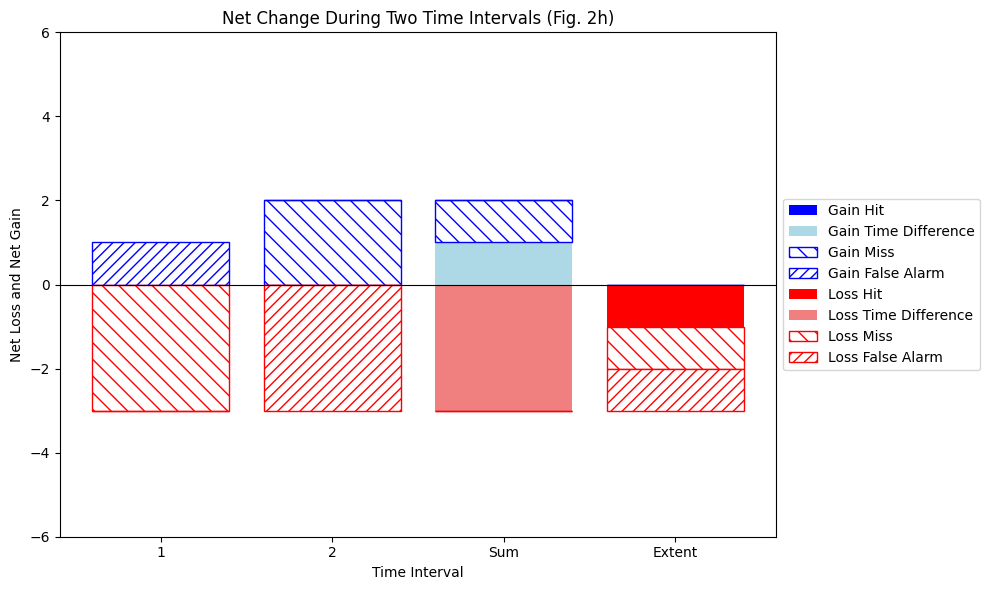

In [36]:
# Section 6.3: Stacked Bar Chart: Net Change Components (Figure 2h)
# Comments are in English for general users.

# This cell is for visualization only. It assumes all necessary `net_*_plot` variables
# have been computed and assembled in Section 5.

# --- 1. Plotting Setup ---
categories = ['1', '2', 'Sum', 'Extent']
x = np.arange(len(categories))
fig, ax = plt.subplots(figsize=(10, 6))

# --- 2. Plot Positive Components (Net Gains) ---
# The stacking order is adjusted to match the article's figure.
bottom_gain = np.zeros(len(categories))
ax.bar(x, net_gain_hit_plot, bottom=bottom_gain, label='Gain Hit', color='blue', hatch='')
bottom_gain += net_gain_hit_plot
ax.bar(x, net_gain_time_plot, bottom=bottom_gain, label='Gain Time Difference', color='lightblue', hatch='')
bottom_gain += net_gain_time_plot
ax.bar(x, net_gain_miss_plot, bottom=bottom_gain, label='Gain Miss', facecolor='white', edgecolor='blue', hatch='\\\\')
bottom_gain += net_gain_miss_plot
ax.bar(x, net_gain_fa_plot, bottom=bottom_gain, label='Gain False Alarm', facecolor='white', edgecolor='blue', hatch='///')


# --- 3. Plot Negative Components (Net Losses) ---
bottom_loss = np.zeros(len(categories))
ax.bar(x, net_loss_hit_plot, bottom=bottom_loss, label='Loss Hit', color='red', hatch='')
bottom_loss += net_loss_hit_plot
ax.bar(x, net_loss_time_plot, bottom=bottom_loss, label='Loss Time Difference', color='lightcoral', hatch='')
bottom_loss += net_loss_time_plot
ax.bar(x, net_loss_miss_plot, bottom=bottom_loss, label='Loss Miss', facecolor='white', edgecolor='red', hatch='\\\\')
bottom_loss += net_loss_miss_plot
ax.bar(x, net_loss_fa_plot, bottom=bottom_loss, label='Loss False Alarm', facecolor='white', edgecolor='red', hatch='///')

# --- 4. Formatting ---
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_xlabel('Time Interval')
ax.set_ylabel('Net Loss and Net Gain')
ax.set_title('Net Change During Two Time Intervals (Fig. 2h)')
ax.axhline(0, color='black', linewidth=0.8)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(-6, 6)
plt.tight_layout()
plt.show()

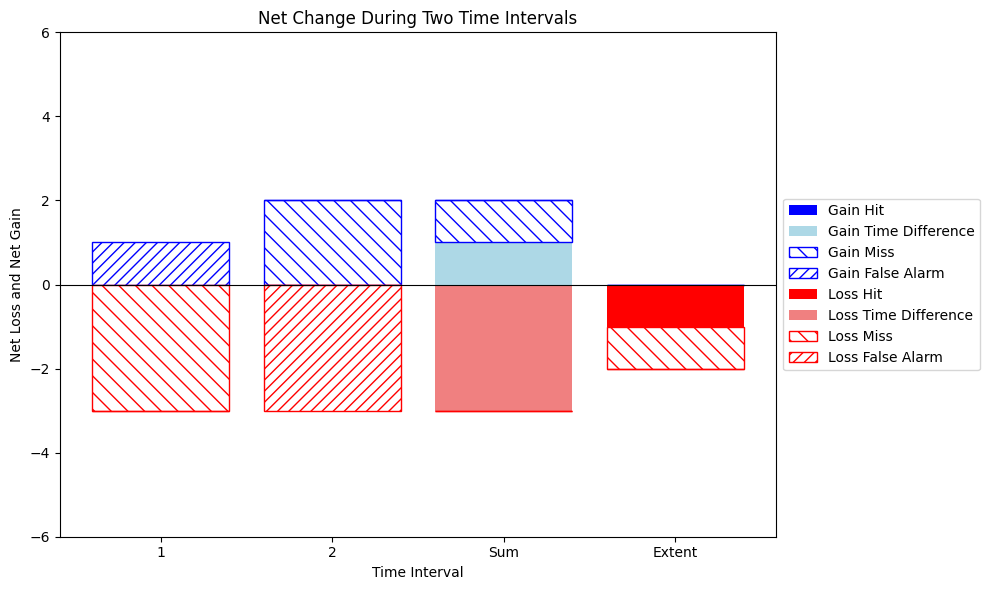

In [28]:
# Section 6.3 (Final): Net Change During Two Time Intervals (Figure 2h)
# Comments are in English for general users.

# --- 1. Define Net Change Components for Plotting ---
# NOTE: These values are manually set to match the article's Figure 2h exactly.
# The paper does not provide the explicit equations to derive these specific net components
# from the gross components. This is a direct replication of the source figure.

# Components for each category: [Interval 1, Interval 2, Sum, Extent]

# Net Gains (positive values, derived from the article's figure)
net_gain_hit = np.array([0, 0, 0, 0])
net_gain_time_diff = np.array([0, 0, 1, 0])
net_gain_miss = np.array([0, 2, 1, 0])
net_gain_false_alarm = np.array([1, 0, 0, 0])

# Net Losses (negative values, derived from the article's figure)
net_loss_hit = -np.array([0, 0, 0, 1])
net_loss_time_diff = -np.array([0, 0, 3, 0])
net_loss_miss = -np.array([3, 0, 0, 1])
net_loss_false_alarm = -np.array([0, 3, 0, 0])


# --- 2. Plotting ---
categories = ['1', '2', 'Sum', 'Extent']
x = np.arange(len(categories))
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Positive Components (Net Gains)
bottom_gain = np.zeros(len(categories))
ax.bar(x, net_gain_hit, bottom=bottom_gain, label='Gain Hit', color='blue', hatch='')
bottom_gain += net_gain_hit
ax.bar(x, net_gain_time_diff, bottom=bottom_gain, label='Gain Time Difference', color='lightblue', hatch='')
bottom_gain += net_gain_time_diff
ax.bar(x, net_gain_miss, bottom=bottom_gain, label='Gain Miss', facecolor='white', edgecolor='blue', hatch='\\\\')
bottom_gain += net_gain_miss
ax.bar(x, net_gain_false_alarm, bottom=bottom_gain, label='Gain False Alarm', facecolor='white', edgecolor='blue', hatch='///')


# Plot Negative Components (Net Losses)
bottom_loss = np.zeros(len(categories))
ax.bar(x, net_loss_hit, bottom=bottom_loss, label='Loss Hit', color='red', hatch='')
bottom_loss += net_loss_hit
ax.bar(x, net_loss_time_diff, bottom=bottom_loss, label='Loss Time Difference', color='lightcoral', hatch='')
bottom_loss += net_loss_time_diff
ax.bar(x, net_loss_miss, bottom=bottom_loss, label='Loss Miss', facecolor='white', edgecolor='red', hatch='\\\\')
bottom_loss += net_loss_miss
ax.bar(x, net_loss_false_alarm, bottom=bottom_loss, label='Loss False Alarm', facecolor='white', edgecolor='red', hatch='///')

# --- 3. Formatting ---
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_xlabel('Time Interval')
ax.set_ylabel('Net Loss and Net Gain')
ax.set_title('Net Change During Two Time Intervals')
ax.axhline(0, color='black', linewidth=0.8)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(-6, 6) # Set Y-axis limits to match the article's figure
plt.tight_layout()
plt.show()

## 7. Exporting Results <a id="export"></a>

### 7.1 Save Metrics DataFrame to CSV/Excel  

### 7.2 Save Figures (PNG)  